<a href="https://colab.research.google.com/github/ashasch/Project2_python/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Запит до бд

In [1]:
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

query = """
SELECT
    s.date AS order_date,
    o.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.medium AS traffic_source,
    sp.channel AS traffic_channel,
    ac.id AS registered_user_id,
    CASE WHEN ac.is_verified = 1 THEN 'Yes' ELSE 'No' END AS is_email_verified,
    CASE WHEN ac.is_unsubscribed = 1 THEN 'No' ELSE 'Yes' END AS is_subscribed,
    p.category AS product_category,
    p.name AS product_name,
    p.price AS product_price,
    p.short_description AS product_description
FROM
    `DA.order` o
LEFT JOIN
    `DA.session` s ON o.ga_session_id = s.ga_session_id
LEFT JOIN
    `DA.session_params` sp ON o.ga_session_id = sp.ga_session_id
LEFT JOIN
    `DA.account_session` acs ON o.ga_session_id = acs.ga_session_id
LEFT JOIN
    `DA.account` ac ON acs.account_id = ac.id
LEFT JOIN
    `DA.product` p ON o.item_id = p.item_id
"""


query_job = client.query(query)
results = query_job.result()

df = results.to_dataframe()
df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,traffic_channel,registered_user_id,is_email_verified,is_subscribed,product_category,product_name,product_price,product_description
0,2020-11-06,7799937037,Europe,Slovakia,mobile,Chrome,<Other>,Web,fr,referral,Paid Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
1,2020-11-10,4020421879,Americas,United States,desktop,Chrome,Safari,Macintosh,en,(none),Direct,653378,Yes,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
2,2020-11-24,6717382496,Americas,United States,desktop,Chrome,Chrome,Web,en-us,referral,Social Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
3,2020-11-26,2093497337,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(none),Direct,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
4,2020-12-03,9506718330,Europe,Spain,desktop,Chrome,ChromeBook,<Other>,en-us,referral,Paid Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"


# Метрики та аналіз

In [4]:
# Загальна кількість колонок
total_columns = df.shape[1]

# Кількість колонок числового типу
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns_count = len(numeric_columns)

# Кількість колонок категоріального типу
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns_count = len(categorical_columns)

# Кількість колонок типу datetime
datetime_columns = df.select_dtypes(include=['datetime']).columns.tolist()
datetime_columns_count = len(datetime_columns)

# Кількість унікальних сесій
unique_sessions = df['ga_session_id'].nunique()

# Перевірка типу даних колонки 'order_date'
print(df['order_date'].dtype)

# Якщо це не datetime, перетворюємо
if not pd.api.types.is_datetime64_any_dtype(df['order_date']):
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Перевірка після перетворення
print(df['order_date'].dtype)

# Обчислюємо період часу
time_period_start = df['order_date'].min()
time_period_end = df['order_date'].max()

# Чи є пропущені значення
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0].index.tolist()

# Колонки з найбільшою кількістю пропущених значень
most_missing_column = missing_values.idxmax()
most_missing_count = missing_values.max()

# Вивід результатів
print(f"Загальна кількість колонок: {total_columns}")
print(f"Кількість числових колонок: {numeric_columns_count}, Числові колонки: {numeric_columns}")
print(f"Кількість категоріальних колонок: {categorical_columns_count}, Категоріальні колонки: {categorical_columns}")
print(f"Кількість колонок типу datetime: {datetime_columns_count}, Datetime колонки: {datetime_columns}")
print(f"Кількість унікальних сесій: {unique_sessions}")
print(f"Період часу: від {time_period_start} до {time_period_end}")
print(f"Чи є пропущені значення: {'Так' if missing_columns else 'Ні'}")
if missing_columns:
    print(f"Колонки з пропущеними значеннями: {missing_columns}")
    print(f"Колонка з найбільшою кількістю пропусків: {most_missing_column} ({most_missing_count} пропусків)")
    print("Можливі причини пропусків залежно від даних:")
    if 'registered_user_id' in missing_columns:
        print("- Незареєстровані користувачі не мають `registered_user_id`")


datetime64[ns]
datetime64[ns]
Загальна кількість колонок: 18
Кількість числових колонок: 3, Числові колонки: ['ga_session_id', 'registered_user_id', 'product_price']
Кількість категоріальних колонок: 14, Категоріальні колонки: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'traffic_channel', 'is_email_verified', 'is_subscribed', 'product_category', 'product_name', 'product_description']
Кількість колонок типу datetime: 1, Datetime колонки: ['order_date']
Кількість унікальних сесій: 33538
Період часу: від 2020-11-01 00:00:00 до 2021-01-27 00:00:00
Чи є пропущені значення: Так
Колонки з пропущеними значеннями: ['language', 'registered_user_id']
Колонка з найбільшою кількістю пропусків: registered_user_id (30757 пропусків)
Можливі причини пропусків залежно від даних:
- Незареєстровані користувачі не мають `registered_user_id`


In [ ]:
# Загальні продажі та кількість замовлень за континентами і країнами
continent_sales = df.groupby('continent')['product_price'].sum().nlargest(3)
country_sales = df.groupby('country')['product_price'].sum().nlargest(5)

continent_orders = df['continent'].value_counts().nlargest(3)
country_orders = df['country'].value_counts().nlargest(5)

print("Топ-3 континенти за продажами:\n", continent_sales, "\n")
print("Топ-5 країн за продажами:\n", country_sales, "\n")
print("Топ-3 континенти за кількістю замовлень:\n", continent_orders, "\n")
print("Топ-5 країн за кількістю замовлень:\n", country_orders)


Топ-3 континенти за продажами:
 continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: product_price, dtype: float64 

Топ-5 країн за продажами:
 country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: product_price, dtype: float64 

Топ-3 континенти за кількістю замовлень:
 continent
Americas    18553
Asia         7950
Europe       6261
Name: count, dtype: int64 

Топ-5 країн за кількістю замовлень:
 country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: count, dtype: int64


In [ ]:
# Знаходимо країну з найбільшими продажами
top_country = df.groupby('country')['product_price'].sum().idxmax()

# Загальні топ-10 категорій
overall_top_categories = df.groupby('product_category')['product_price'].sum().nlargest(10)

# Топ-10 категорій у країні з найбільшими продажами
country_top_categories = df[df['country'] == top_country].groupby('product_category')['product_price'].sum().nlargest(10)

print(f"Країна з найбільшими продажами: {top_country}")
print("\nЗагальні топ-10 категорій товарів:")
print(overall_top_categories)

print(f"\nТоп-10 категорій у {top_country}:")
print(country_top_categories)

# Перевірка на відмінності
if overall_top_categories.index.tolist() == country_top_categories.index.tolist():
    print("\nТоп-10 категорій товарів у цій країні збігаються з загальними.")
else:
    print("\nТоп-10 категорій товарів у цій країні відрізняються від загальних.")


Країна з найбільшими продажами: United States

Загальні топ-10 категорій товарів:
product_category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: product_price, dtype: float64

Топ-10 категорій у United States:
product_category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer unit

In [ ]:
# Продажі за моделями девайсів
device_sales = df.groupby('mobile_model_name')['product_price'].sum()
device_percentage = (device_sales / device_sales.sum()) * 100
print("Продажі за моделями девайсів (%):\n", device_percentage, "\n")

# Продажі за джерелами трафіку
traffic_sales = df.groupby('traffic_source')['product_price'].sum()
traffic_percentage = (traffic_sales / traffic_sales.sum()) * 100
print("Продажі за джерелами трафіку (%):\n", traffic_percentage)


Продажі за моделями девайсів (%):
 mobile_model_name
<Other>       20.440966
Chrome        27.835602
ChromeBook     5.725241
Edge           2.180746
Firefox        1.316998
Pixel 3        0.341390
Pixel 4 XL     0.369976
Safari        20.302504
iPad           1.403910
iPhone        20.082667
Name: product_price, dtype: float64 

Продажі за джерелами трафіку (%):
 traffic_source
(data deleted)     6.386645
(none)            23.442345
<Other>           14.047882
cpc                4.273902
organic           34.202840
referral          17.646386
Name: product_price, dtype: float64


In [ ]:
# Підтверджені email
confirmed_emails = df['is_email_verified'].value_counts(normalize=True) * 100
print("Відсоток підтверджених email:\n", confirmed_emails, "\n")

# Відписані користувачі
subscribed_users = df['is_subscribed'].value_counts(normalize=True) * 100
print("Відсоток підписаних користувачів:\n", subscribed_users)


Відсоток підтверджених email:
 is_email_verified
No     94.069414
Yes     5.930586
Name: proportion, dtype: float64 

Відсоток підписаних користувачів:
 is_subscribed
Yes    98.667183
No      1.332817
Name: proportion, dtype: float64


In [ ]:
# Групуємо дані за країнами та підраховуємо кількість зареєстрованих користувачів
top_countries_by_users = df.groupby('country')['registered_user_id'].nunique().nlargest(10)

print("Топ-10 країн за кількістю зареєстрованих користувачів:")
print(top_countries_by_users)


Топ-10 країн за кількістю зареєстрованих користувачів:
country
United States     1207
India              246
Canada             207
United Kingdom      88
France              56
Germany             56
Taiwan              51
China               48
Spain               48
Singapore           44
Name: registered_user_id, dtype: int64


# Аналіз динаміки продажів

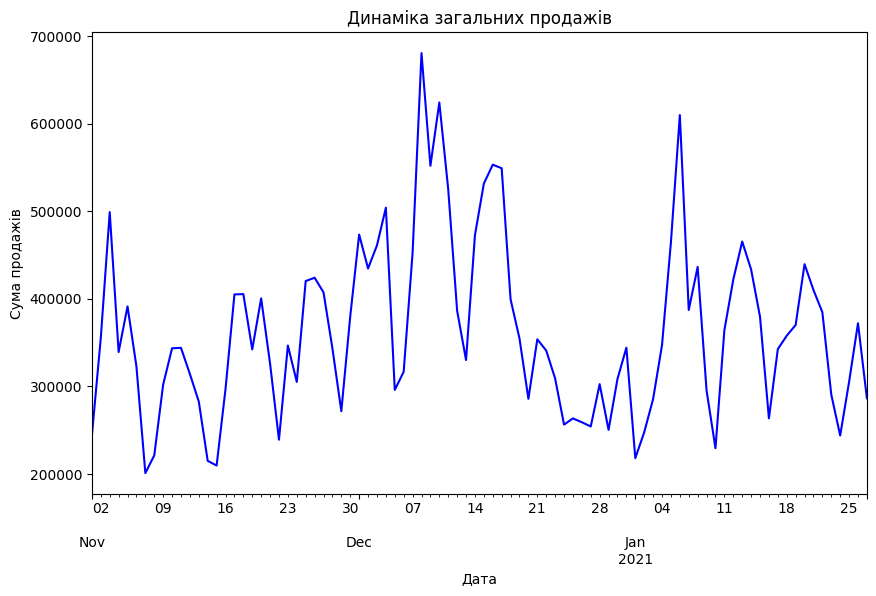

In [ ]:
sales_by_date = df.groupby('order_date')['product_price'].sum()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sales_by_date.plot(title="Динаміка загальних продажів", color="blue")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.show()


Графік демонструє значну мінливість загальних продажів протягом аналізованого періоду (листопад-січень). Спостерігаються як періоди значного зростання, так і періоди спаду.

Продажі демонструють значні коливання від місяця до місяця, а також протягом кожного місяця. Це свідчить про вплив різних факторів на обсяги продажів, таких як сезонність, маркетингові кампанії, зміни в асортименті товарів тощо.
Піки продажів: Спостерігаються кілька піків продажів, які можуть бути пов'язані з певними подіями або періодами високого попиту (наприклад, перед святами).

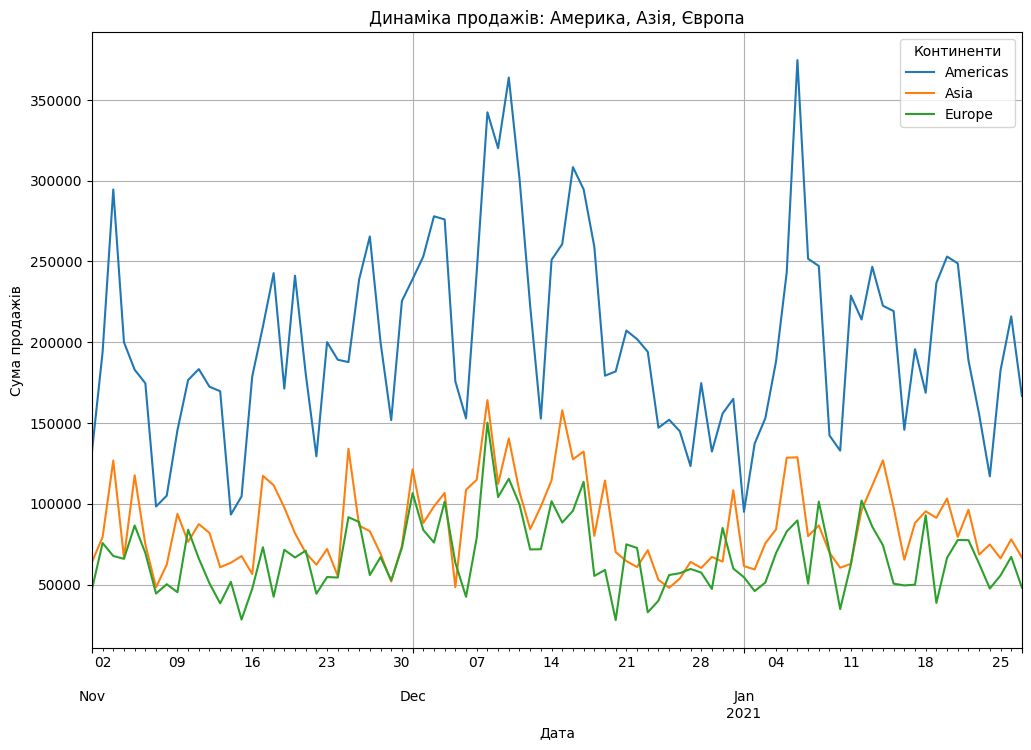

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])

# Групування даних: продажі за континентами та датами
continent_sales_by_date = df.groupby(['order_date', 'continent'])['product_price'].sum().unstack()

# Відфільтровуємо дані для Америки, Азії та Європи
filtered_continents = ['Americas', 'Asia', 'Europe']
filtered_sales = continent_sales_by_date[filtered_continents]

# Побудова графіку
filtered_sales.plot(
    title="Динаміка продажів: Америка, Азія, Європа",
    figsize=(12, 8)
)
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Континенти")
plt.grid(True)
plt.show()

Графік демонструє динаміку продажів за трьома континентами (Америка, Азія, Європа) протягом певного періоду (листопад-січень). Кожна лінія на графіку відповідає одному континенту, що дозволяє порівняти їхні продажі та виявити загальні тренди та відмінності.

Всі три континенти демонструють певну сезонність продажів. Спостерігаються піки та спади, які можуть бути пов'язані з різними факторами, такими як свята, кліматичні умови, маркетингові кампанії тощо. Незважаючи на відмінності, між континентами спостерігається певна кореляція. Наприклад, піки продажів на одному континенті можуть супроводжуватися піками на інших континентах, що може свідчити про вплив глобальних економічних факторів або трендів.

Колонки в 'traffic_sales_by_date': Index(['Direct', 'Organic Search', 'Paid Search', 'Social Search',
       'Undefined'],
      dtype='object', name='traffic_channel')


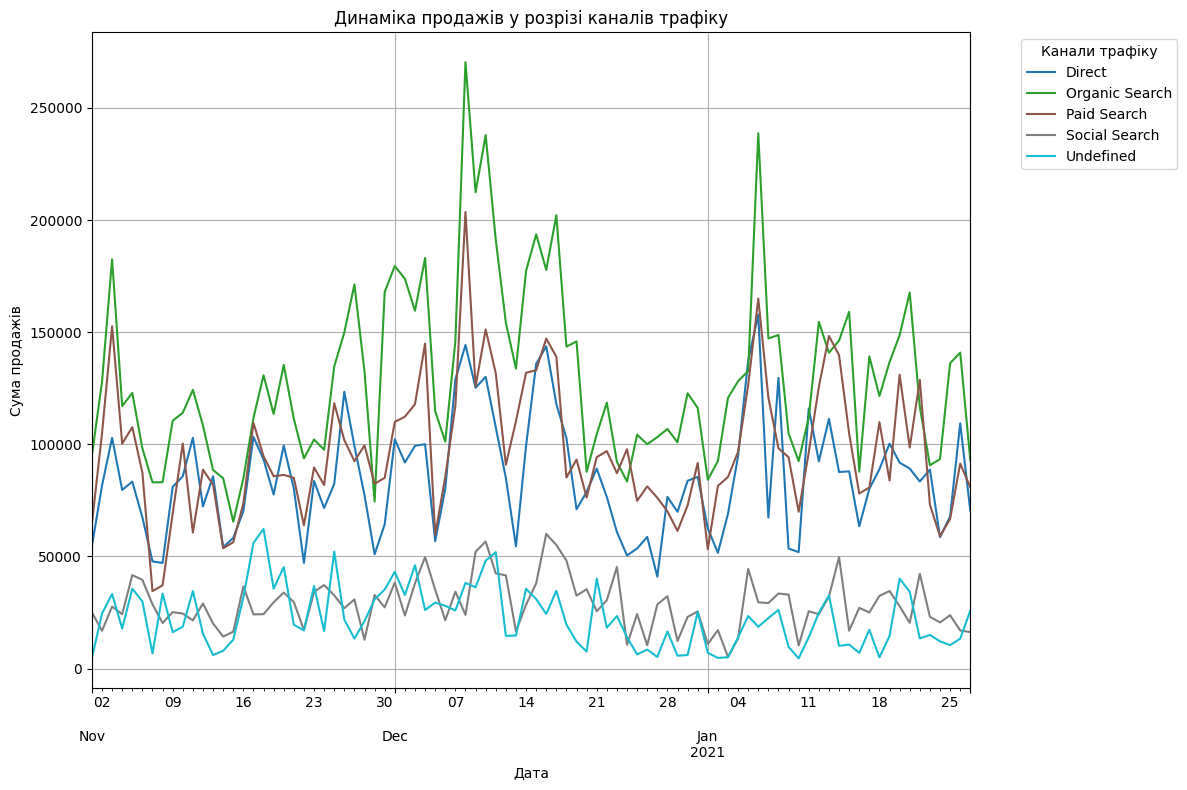

In [ ]:
# Групування даних за датою та каналами трафіку
traffic_sales_by_date = df.groupby(['order_date', 'traffic_channel'])['product_price'].sum().unstack()

# Перевірка наявності даних
print("Колонки в 'traffic_sales_by_date':", traffic_sales_by_date.columns)

# Побудова графіку для каналів трафіку
traffic_sales_by_date.plot(
    title="Динаміка продажів у розрізі каналів трафіку",
    figsize=(12, 8),
    colormap='tab10'  # Використовуємо набір кольорів для різних каналів
)
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Канали трафіку", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Графік демонструє, як змінювалися обсяги продажів за різними каналами трафіку протягом певного періоду (листопад-січень). Кожна лінія на графіку відповідає одному каналу трафіку (Direct, Organic Search, Paid Search, Social Search, Undefined), що дозволяє порівняти їхній внесок у загальний обсяг продажів та виявити загальні тренди та відмінності.

Спостерігається певна сезонність продажів для всіх каналів трафіку. Це може бути пов'язано з різними факторами, такими як свята, сезонні акції, зміни попиту на товари або послуги.

Колонки в 'device_sales_by_date': Index(['desktop', 'mobile', 'tablet'], dtype='object', name='device')


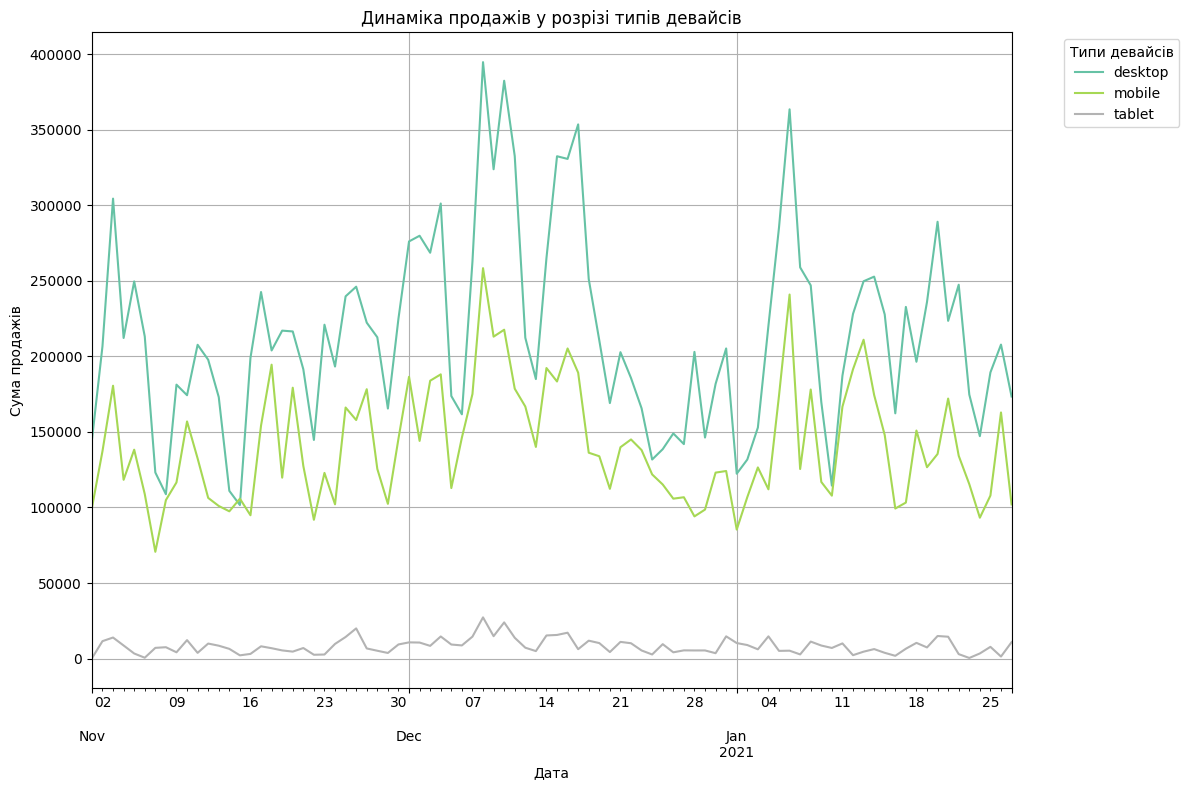

In [ ]:
# Групування даних за датою та типами девайсів
device_sales_by_date = df.groupby(['order_date', 'device'])['product_price'].sum().unstack()

# Перевірка наявності даних
print("Колонки в 'device_sales_by_date':", device_sales_by_date.columns)

# Побудова графіку для типів девайсів
device_sales_by_date.plot(
    title="Динаміка продажів у розрізі типів девайсів",
    figsize=(12, 8),
    colormap='Set2'  # Інший набір кольорів для різних девайсів
)
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Типи девайсів", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Графік наочно демонструє, як змінювалися обсяги продажів залежно від типу пристрою (десктоп, мобільний, планшет) протягом певного періоду (листопад-січень). Кожна лінія на графіку відповідає одному типу пристрою, що дозволяє порівняти їхній внесок у загальний обсяг продажів та виявити загальні тренди та відмінності.

З графіка видно, що найбільший обсяг продажів припадає на десктопні пристрої. Це може свідчити про те, що більшість покупців все ще віддають перевагу здійснювати покупки з персональних комп'ютерів або ноутбуків. Хоча десктопи і лідирують, спостерігається стійка тенденція до зростання продажів з мобільних пристроїв. Це свідчить про те, що все більше користувачів переходять на онлайн-шопінг з телефонів або планшетів.

Топ-10 днів з найбільшою волатильністю:
order_date
2020-12-08    228086.2
2021-01-07    222600.1
2020-12-05    208043.7
2020-11-04    159792.5
2020-12-18    149756.7
2021-01-06    145219.1
2020-11-03    143472.8
2020-12-14    142610.4
2021-01-09    141031.6
2020-12-12    138635.1
Name: product_price, dtype: float64


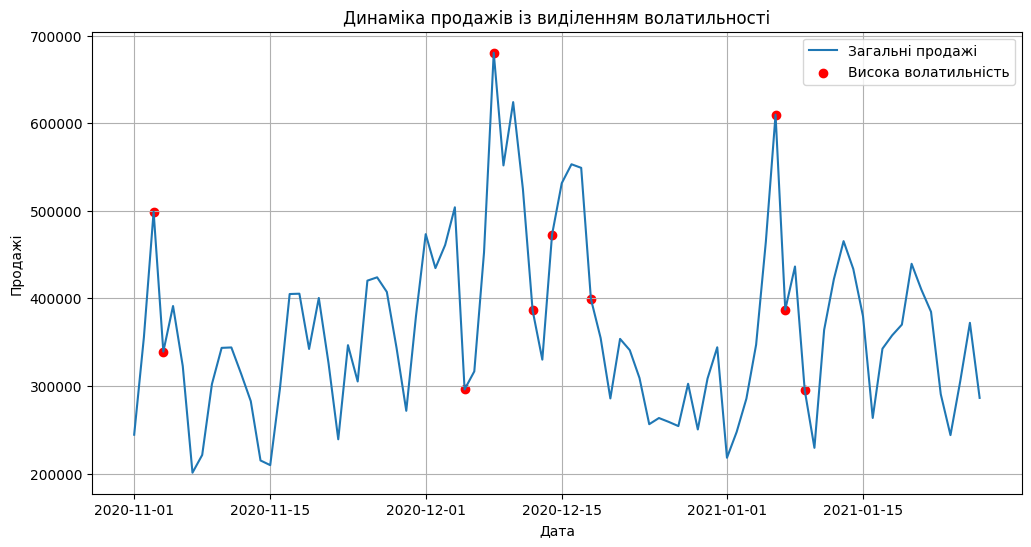

In [ ]:
# Групуємо дані за датою і знаходимо загальні продажі
daily_sales = df.groupby('order_date')['product_price'].sum().sort_index()

# Обчислюємо зміну продажів (різницю між днями)
sales_volatility = daily_sales.diff().abs()

# Знаходимо дні з найвищою волатильністю
top_volatility_days = sales_volatility.nlargest(10)

print("Топ-10 днів з найбільшою волатильністю:")
print(top_volatility_days)

# Візуалізація
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales, label="Загальні продажі")
plt.scatter(top_volatility_days.index, daily_sales[top_volatility_days.index], color='red', label="Висока волатильність")
plt.title("Динаміка продажів із виділенням волатильності")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.legend()
plt.grid()
plt.show()


Графік наочно демонструє, як змінювалися обсяги продажів протягом певного періоду (листопад 2020 - січень 2021) та виділяє дні, коли спостерігалися найбільші коливання продажів (висока волатильність). Червоними точками позначені дні, коли відхилення від попереднього дня було найбільшим.



# Зведені таблиці

In [ ]:
session_pivot = pd.pivot_table(
    df,
    values='ga_session_id',
    index='traffic_channel',
    columns='device',
    aggfunc='count'
)
print("Кількість сесій за каналами трафіку та типами девайсів:\n", session_pivot)

Кількість сесій за каналами трафіку та типами девайсів:
 device           desktop  mobile  tablet
traffic_channel                         
Direct              4655    2985     160
Organic Search      7011    4655     255
Paid Search         5261    3574     207
Social Search       1594    1065      57
Undefined           1181     834      44


In [ ]:
# Підрахуємо загальні продажі по країнах
country_sales = df.groupby('country')['product_price'].sum().sort_values(ascending=False)

# Вибираємо топ-5 країн
top_countries = country_sales.head(5).index.tolist()

# Підрахуємо загальні продажі по категоріях товарів
category_sales = df.groupby('product_category')['product_price'].sum().sort_values(ascending=False)

# Вибираємо топ-10 категорій
top_categories = category_sales.head(10).index.tolist()

# Створюємо зведену таблицю для топ-10 категорій та топ-5 країн
top_categories_pivot = df[df['country'].isin(top_countries) & df['product_category'].isin(top_categories)].pivot_table(
    values='product_price',
    index='product_category',
    columns='country',
    aggfunc='sum'
)

# Вивести зведену таблицю
print("Загальні продажі за категоріями товарів у топ-5 країнах:\n", top_categories_pivot)


Загальні продажі за категоріями товарів у топ-5 країнах:
 country                             Canada    France     India  \
product_category                                                 
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
product_category                                                 
Bar furniture    

Середній чек для кожного типу пристрою та каналу трафіку:
traffic_channel      Direct  Organic Search  Paid Search  Social Search  \
device                                                                    
desktop          960.818346      969.064014   946.013648     908.020577   
mobile           963.255578      947.126767   931.738276     945.265070   
tablet           918.725625      902.622353   985.695652    1368.659649   

traffic_channel    Undefined  
device                        
desktop           993.191533  
mobile            915.219305  
tablet           1460.202273  


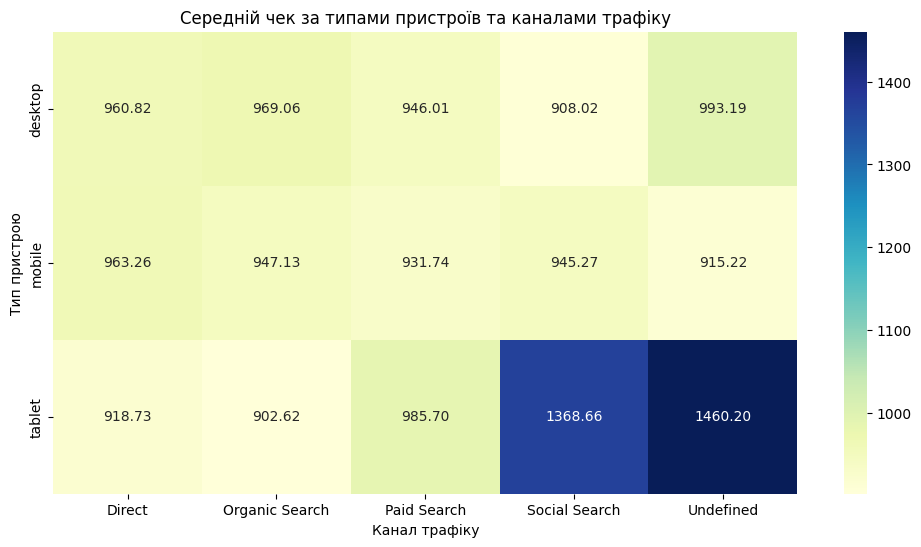

In [ ]:
pivot_avg_order = df.pivot_table(
    index='device',
    columns='traffic_channel',
    values='product_price',
    aggfunc='mean'
)

print("Середній чек для кожного типу пристрою та каналу трафіку:")
print(pivot_avg_order)

# Візуалізація теплової карти
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg_order, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Середній чек за типами пристроїв та каналами трафіку")
plt.xlabel("Канал трафіку")
plt.ylabel("Тип пристрою")
plt.show()


Загальні продажі для кожного континенту та каналу трафіку:
traffic_channel     Direct  Organic Search  Paid Search  Social Search  \
continent                                                                
(not set)          21443.0         15080.0      19931.0        11224.4   
Africa             70028.0        129908.4      88195.0        31187.6   
Americas         4222962.0       6294563.2    4627454.3      1384427.7   
Asia             1755294.5       2725953.8    2039256.5       576031.8   
Europe           1343093.9       2154138.6    1620206.1       498507.1   
Oceania            82102.0        113507.6     116006.5        30727.1   

traffic_channel  Undefined  
continent                   
(not set)           6389.0  
Africa             11912.0  
Americas         1135872.8  
Asia              504761.7  
Europe            318678.5  
Oceania            22887.0  


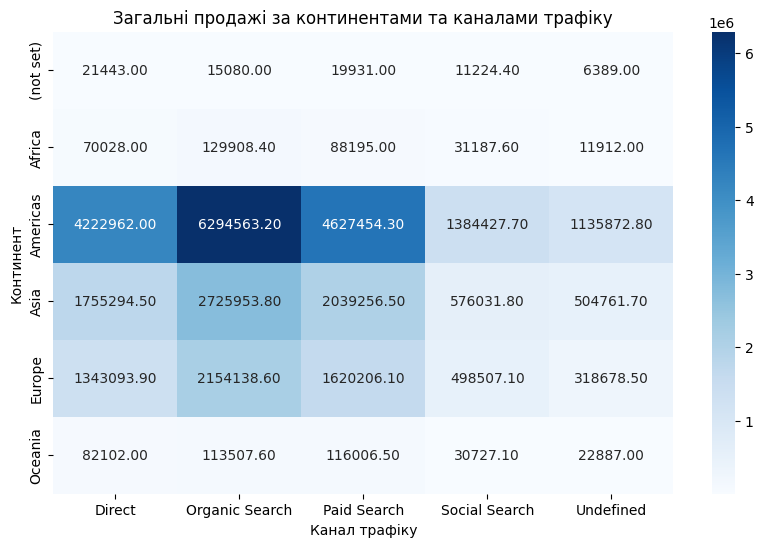

In [ ]:
pivot_sales = df.pivot_table(
    index='continent',
    columns='traffic_channel',
    values='product_price',
    aggfunc='sum'
)

print("Загальні продажі для кожного континенту та каналу трафіку:")
print(pivot_sales)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sales, annot=True, fmt=".2f", cmap="Blues")
plt.title("Загальні продажі за континентами та каналами трафіку")
plt.xlabel("Канал трафіку")
plt.ylabel("Континент")
plt.show()


# Статистичний аналіз взаємозв’язків

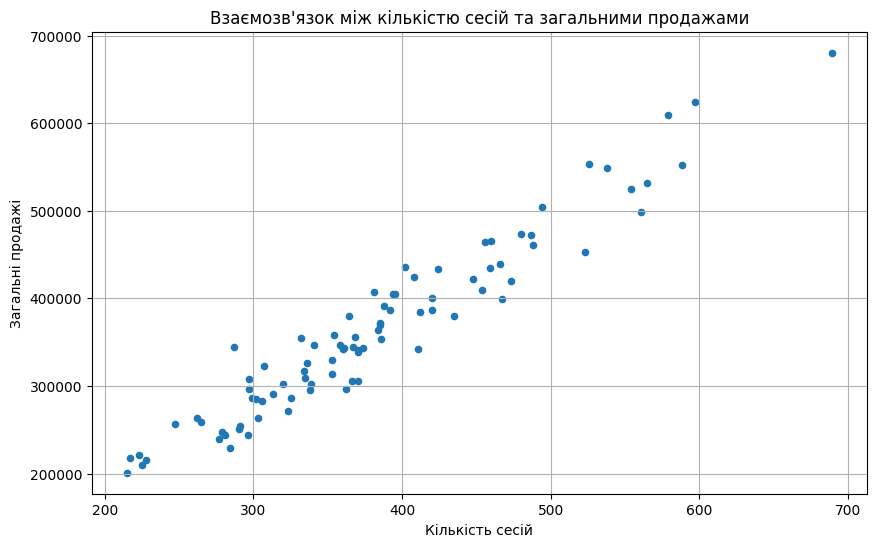

Коефіцієнт кореляції: 0.96, p-значення: 2.2447783149167257e-51
Кореляція статистично значуща.


In [ ]:
from scipy.stats import pearsonr

# Кількість сесій та продажі за кожну дату
sessions_sales = df.groupby('order_date').agg(
    total_sessions=('ga_session_id', 'nunique'),
    total_sales=('product_price', 'sum')
)

# Візуалізація
sessions_sales.plot(
    kind='scatter',
    x='total_sessions',
    y='total_sales',
    figsize=(10, 6),
    title="Взаємозв'язок між кількістю сесій та загальними продажами"
)
plt.xlabel("Кількість сесій")
plt.ylabel("Загальні продажі")
plt.grid(True)
plt.show()

# Кореляція
correlation, p_value = pearsonr(sessions_sales['total_sessions'], sessions_sales['total_sales'])
print(f"Коефіцієнт кореляції: {correlation:.2f}, p-значення: {p_value}")
if p_value < 0.05:
    print("Кореляція статистично значуща.")
else:
    print("Кореляція не є статистично значущою.")


Отриманий коефіцієнт кореляції 0.96 свідчить про дуже сильну позитивну лінійну залежність між кількістю сесій на сайті та загальним обсягом продажів. Це означає, що зі збільшенням кількості сесій, як правило, зростають і загальні продажі.

Низьке p-значення (менше 0.05) вказує на те, що така висока кореляція є статистично значущою. Це означає, що малоймовірно, що спостережуваний зв'язок виник випадково.

In [ ]:
import seaborn as sns
# Загальні продажі за кожен континент і дату
continent_sales = df.groupby(['order_date', 'continent'])['product_price'].sum().unstack()

# Вибір топ-3 континентів за загальними продажами
top_3_continents = continent_sales.sum().nlargest(3).index
filtered_continent_sales = continent_sales[top_3_continents]

# Кореляційна матриця
correlation_matrix = filtered_continent_sales.corr()
print("Кореляційна матриця для продажів на континентах:")
print(correlation_matrix)

Кореляційна матриця для продажів на континентах:
continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.692273  0.669527
Asia       0.692273  1.000000  0.667786
Europe     0.669527  0.667786  1.000000


Кореляційна матриця, яку отримали, демонструє ступінь взаємозв'язку між продажами на різних континентах. Кожен елемент матриці представляє коефіцієнт кореляції між двома континентами, тобто наскільки зміни в продажах на одному континенті пов'язані зі змінами на іншому.

Високі значення коефіцієнтів кореляції (близькі до 1) між усіма парами континентів свідчать про те, що існує сильна позитивна лінійна залежність між продажами на різних континентах. Це означає, що коли продажі зростають на одному континенті, вони, як правило, зростають і на інших. Така сильна кореляція може вказувати на наявність загальних трендів, які впливають на продажі на всіх континентах. Це можуть бути глобальні економічні фактори, сезонність, маркетингові кампанії, які охоплюють кілька континентів одночасно.

In [ ]:
# Загальні продажі за кожен канал і дату
channel_sales = df.groupby(['order_date', 'traffic_channel'])['product_price'].sum().unstack()

# Кореляційна матриця
channel_correlation_matrix = channel_sales.corr()
print("Кореляційна матриця для продажів за каналами трафіку:")
print(channel_correlation_matrix)


Кореляційна матриця для продажів за каналами трафіку:
traffic_channel    Direct  Organic Search  Paid Search  Social Search  \
traffic_channel                                                         
Direct           1.000000        0.759938     0.724343       0.461895   
Organic Search   0.759938        1.000000     0.808234       0.434424   
Paid Search      0.724343        0.808234     1.000000       0.452287   
Social Search    0.461895        0.434424     0.452287       1.000000   
Undefined        0.424039        0.435418     0.430021       0.359342   

traffic_channel  Undefined  
traffic_channel             
Direct            0.424039  
Organic Search    0.435418  
Paid Search       0.430021  
Social Search     0.359342  
Undefined         1.000000  


Кореляційна матриця, яку отримали, демонструє ступінь взаємозв'язку між продажами, отриманими з різних каналів трафіку (прямий, органічний пошук, платний пошук, соціальні мережі, невизначений). Кожен елемент матриці представляє коефіцієнт кореляції між двома каналами, тобто наскільки зміни в продажах з одного каналу пов'язані зі змінами в продажах з іншого.

Така сильна кореляція може вказувати на наявність загальних трендів, які впливають на продажі з усіх каналів. Це можуть бути загальні економічні фактори, сезонність, маркетингові кампанії, які охоплюють кілька каналів одночасно.

In [ ]:
# Загальні продажі за категоріями товарів
category_sales = df.groupby(['order_date', 'product_category'])['product_price'].sum().unstack()

# Вибір топ-5 категорій за загальними продажами
top_5_categories = category_sales.sum().nlargest(5).index
filtered_category_sales = category_sales[top_5_categories]

# Кореляційна матриця
category_correlation_matrix = filtered_category_sales.corr()
print("Кореляційна матриця для продажів за категоріями товарів:")
print(category_correlation_matrix)



Кореляційна матриця для продажів за категоріями товарів:
product_category            Sofas & armchairs    Chairs      Beds  \
product_category                                                    
Sofas & armchairs                    1.000000  0.578248  0.535378   
Chairs                               0.578248  1.000000  0.554500   
Beds                                 0.535378  0.554500  1.000000   
Bookcases & shelving units           0.666194  0.637090  0.592913   
Cabinets & cupboards                 0.657563  0.572870  0.514609   

product_category            Bookcases & shelving units  Cabinets & cupboards  
product_category                                                              
Sofas & armchairs                             0.666194              0.657563  
Chairs                                        0.637090              0.572870  
Beds                                          0.592913              0.514609  
Bookcases & shelving units                    1.000000          

Кореляційна матриця, яку отримали, демонструє ступінь взаємозв'язку між продажами різних категорій товарів. Кожен елемент матриці представляє коефіцієнт кореляції між двома категоріями, тобто наскільки зміни в продажах однієї категорії пов'язані зі змінами в продажах іншої.

Висока кореляція свідчить про те, що категорії товарів взаємопов'язані. Зміни в одній категорії можуть викликати зміни в інших. Наприклад, зростання продажів меблів для спальні може спричинити зростання продажів меблів для вітальні. Така сильна кореляція може вказувати на наявність загальних трендів, які впливають на продажі всіх категорій. Це можуть бути загальні економічні фактори, сезонність, маркетингові кампанії, які охоплюють кілька категорій одночасно.

In [ ]:
# Групуємо дані за країною
country_stats = df.groupby('country').agg(
    total_sessions=('ga_session_id', 'count'),
    avg_price=('product_price', 'mean')
).dropna()

# Обчислюємо кореляцію
from scipy.stats import pearsonr

correlation, p_value = pearsonr(country_stats['total_sessions'], country_stats['avg_price'])

print(f"Коефіцієнт кореляції: {correlation:.2f}, p-значення: {p_value:.4f}")
if p_value < 0.05:
    print("Існує статистично значущий взаємозв'язок між кількістю сесій і середньою ціною продуктів.")
else:
    print("Взаємозв'язок між кількістю сесій і середньою ціною продуктів не є статистично значущим.")


Коефіцієнт кореляції: 0.02, p-значення: 0.8127
Взаємозв'язок між кількістю сесій і середньою ціною продуктів не є статистично значущим.


Проведений аналіз не виявив статистично значущого зв'язку між загальною кількістю сесій та середньою ціною продуктів по країнах. Це означає, що зміни в кількості відвідувань сайту з різних країн не супроводжуються систематичними змінами в середній вартості придбаних товарів.

Кількість відвідувачів з певної країни не впливає на середню вартість покупок, зроблених цими відвідувачами.

# Аналіз відмінностей між групами

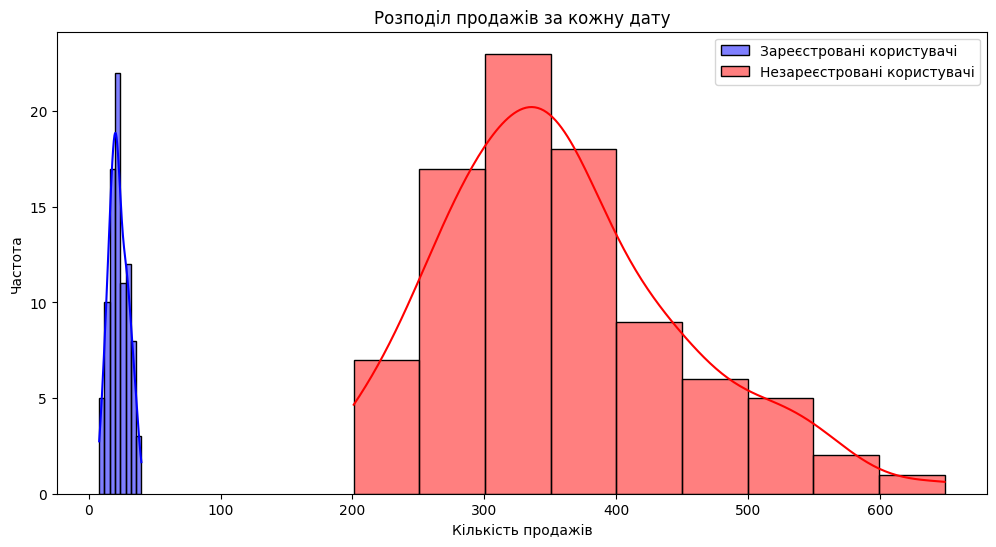

Нормальність для зареєстрованих: p = 0.2930246959239758
Нормальність для незареєстрованих: p = 0.009807951290515282


In [ ]:
# Фільтруємо дані для зареєстрованих та незареєстрованих користувачів
registered_users = df[df['is_email_verified'] == 'Yes']
unregistered_users = df[df['is_email_verified'] == 'No']

# Групуємо дані за датою та підраховуємо продажі (кількість замовлень)
registered_sales_by_date = registered_users.groupby('order_date').size()
unregistered_sales_by_date = unregistered_users.groupby('order_date').size()

# Візуалізація розподілу продажів за датою
plt.figure(figsize=(12, 6))
sns.histplot(registered_sales_by_date, kde=True, color='blue', label='Зареєстровані користувачі')
sns.histplot(unregistered_sales_by_date, kde=True, color='red', label='Незареєстровані користувачі')
plt.legend()
plt.title('Розподіл продажів за кожну дату')
plt.xlabel('Кількість продажів')
plt.ylabel('Частота')
plt.show()

from scipy.stats import shapiro

# Тест Шапіро-Уілка для перевірки нормальності
stat_registered, p_registered = shapiro(registered_sales_by_date)
stat_unregistered, p_unregistered = shapiro(unregistered_sales_by_date)

print(f"Нормальність для зареєстрованих: p = {p_registered}")
print(f"Нормальність для незареєстрованих: p = {p_unregistered}")

# Якщо p > 0.05, то дані мають нормальний розподіл

На представленому графіку зображено розподіл кількості продажів за кожну дату для зареєстрованих та незареєстрованих користувачів. Видно, що розподіл для зареєстрованих користувачів більш широкий і має менше піків, ніж для незареєстрованих. Це може свідчити про більш стабільні продажі серед зареєстрованих клієнтів.

Тест Шапіро-Вілка підтверджує, що розподіл продажів для зареєстрованих користувачів є нормальним (p-значення > 0.05), тоді як для незареєстрованих користувачів відхиляється від нормального розподілу (p-значення < 0.05). Це означає, що статистичні методи, які припускають нормальний розподіл, можуть бути застосовані для аналізу даних про зареєстрованих користувачів, але не для незареєстрованих.

In [ ]:
# Групуємо дані за каналом трафіку та підраховуємо кількість сесій
sessions_by_channel = df.groupby('traffic_channel')['ga_session_id'].nunique()

from scipy.stats import kruskal

# Групуємо дані за каналами трафіку та підраховуємо кількість сесій
sessions_by_channel_groups = [df[df['traffic_channel'] == channel]['ga_session_id'].nunique() for channel in df['traffic_channel'].unique()]

# Краскала-Уолліс тест
h_stat, p_value_kruskal = kruskal(*sessions_by_channel_groups)
print(f"Краскала-Уолліс: p-value = {p_value_kruskal}")


Краскала-Уолліс: p-value = 0.40600584970983794


Отримане p-значення (0.406) більше 0.05, що означає, що ми не можемо відхилити нульову гіпотезу про те, що середні ранги кількості сесій для всіх каналів трафіку однакові.

На основі отриманих результатів можна зробити висновок, що немає достатніх доказів для того, щоб стверджувати, що кількість сесій, які генерують різні канали трафіку, суттєво відрізняється.

# Висновки

Основні висновки:
1. Географічні відмінності:
* Найбільший обсяг продажів припадає на Америку, зокрема на США.
* Існує помітна кореляція між продажами на різних континентах, що свідчить про вплив глобальних трендів та факторів.
2. Популярність категорій товарів:
* Найпопулярнішими категоріями товарів є меблі для вітальні (дивани, крісла), спальні (ліжка) та зберігання (шафи, стелажі).
* Топ-10 категорій товарів в США збігається із загальним топ-10, що свідчить про схожість споживчих уподобань.
3. Вплив каналів трафіку:
* Органічний пошук є найбільш ефективним каналом для залучення клієнтів та генерації продажів.
* Існує сильна кореляція між різними каналами трафіку, що вказує на взаємодію між ними.
4. Роль мобільних пристроїв:
* Спостерігається зростання продажів з мобільних пристроїв, що свідчить про важливість оптимізації сайту для мобільних користувачів.
5. Сезонність продажів:
* Продажі демонструють сезонні коливання, що пов'язано з різними факторами, такими як свята, кліматичні умови та маркетингові кампанії.
6. Вплив зареєстрованих користувачів:
* Більшість покупок здійснюють незареєстровані користувачі. Однак, зареєстровані користувачі демонструють більш високу лояльність і можуть бути цільовою аудиторією для додаткових маркетингових кампаній.
7. Кореляція між кількістю сесій та продажами:
* Існує сильна позитивна кореляція між кількістю сесій на сайті та загальним обсягом продажів, що підтверджує важливість залучення трафіку.


Проведений аналіз даних дозволив отримати цінну інформацію про бізнес та виявити ключові напрямки для подальшого розвитку. Реалізація запропонованих рекомендацій дозволить оптимізувати маркетингові стратегії, підвищити ефективність продажів та збільшити прибутковість бізнесу.

# Дашдорд

[Посилання на дашборд](https://public.tableau.com/views/portfolio_project_17343834572710/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)